In [30]:
strategy_name = '培宏量化1号'

In [31]:
#%load_ext line_profiler
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\github\coresearch\funcs")
import importlib
import rschLib
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData

with open(r"d:\pkl\dailyBarMtx.pkl", 'rb+') as f:
    z = pickle.load(f)
dtes = z['dtes']
dtes = np.array(dtes).astype(np.int)
tkrs = list(z['tkrs'])
open_mtx = z['open_mtx']
high_mtx = z['high_mtx']
low_mtx = z['low_mtx']
close_mtx = z['close_mtx']

k = close_mtx==0
close_mtx = rschLib.zero2pre(close_mtx)
open_mtx[k]=close_mtx[k]
high_mtx[k]=close_mtx[k]
low_mtx[k]=close_mtx[k]

name = z['name']
belong = z['belong']
shenwan1 = z['shenwan1']
shenwan2 = z['shenwan2']
shenwan3 = z['shenwan3']
vol_mtx = z['vol_mtx']
amount_mtx = z['amount_mtx']


In [32]:
maxD = 4

In [33]:
dd = list(dbt.minuteBarStock.find({'ticker':'SH601988', 'dateAsInt':{'$gte':int(20200106), '$lte':int(20200109)}}, {'dateTime':1}))
timeAsFloat = []
for x in dd:
    l  = str(x['dateTime']+datetime.timedelta(hours=8))
    dl = float(l[0:4]+l[5:7]+l[8:10]+'.'+l[11:13]+l[14:16]+l[17:19])
    timeAsFloat.append(dl)
timeAsFloat=np.round(np.array(sorted(list(set([x - int(x) for x in timeAsFloat])))), 6)
timeLabels = []
dayOff = []
for i in range(maxD):
    for x in timeAsFloat:
        s = str(int(x*1e4))
        if len(s)<4:
            s='0'+s
        timeLabels.append('第'+str(i+1)+'天'+s[:2]+':'+s[2:4])
        dayOff.append(i)
timeAsFloat = list(timeAsFloat)*maxD
t = np.round(np.array(sorted(list(set([x - int(x) for x in timeAsFloat])))), 6)
maxM = t.shape[0] * maxD

In [34]:
trades = list(db.strategyBackTestTrades.find({'strategy_name':strategy_name}))
tradesUsed = []
Po = []
Ph = []
Pl = []
Pc = []
for (i,x) in enumerate(trades):
    #if (x['name'] in list(name)):
    p = list(name).index(x['name'])
    ticker = tkrs[p]
    d0 = x['dateIn']
    q = list(dtes).index(d0)
    j = np.min((q+maxD, dtes.shape[0]-1))
    d1 = dtes[j]
    dd = list(dbt.minuteBarStock.find({'ticker':ticker, 'dateAsInt':{'$gte':int(d0), '$lt':int(d1)}}, {'open':1, 'high':1, 'low':1,'close':1, 'dateTime':1}).sort([('dateTime',1)]))
    if dd==[]:
        continue
    tradesUsed.append(x)
    q = np.array([x['open'] for x in dd])
    print(i, '/', len(trades),len(q),dd[0]['dateTime'],dd[-1]['dateTime'])
    z = np.min((len(q),maxM))
    m = np.zeros(maxM)
    m[:z] = q[:z]
    m[z:] = m[z-1]
    Po.append(m)
    #q = np.array([x['high'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Ph.append(m)
    #q = np.array([x['low'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Pl.append(m)
    #q = np.array([x['close'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Pc.append(m)
Po = np.array(Po)
#Ph = np.array(Ph)
#Pl = np.array(Pl)
#Pc = np.array(Pc)

0 / 1070 960 2018-01-03 01:31:00 2018-01-08 07:00:00
1 / 1070 960 2018-01-04 01:31:00 2018-01-09 07:00:00
2 / 1070 960 2018-01-04 01:31:00 2018-01-09 07:00:00
3 / 1070 960 2018-01-05 01:31:00 2018-01-10 07:00:00
4 / 1070 960 2018-01-05 01:31:00 2018-01-10 07:00:00
5 / 1070 960 2018-01-08 01:31:00 2018-01-11 07:00:00
6 / 1070 960 2018-01-10 01:31:00 2018-01-15 07:00:00
7 / 1070 960 2018-01-11 01:31:00 2018-01-16 07:00:00
8 / 1070 960 2018-01-11 01:31:00 2018-01-16 07:00:00
9 / 1070 960 2018-01-12 01:31:00 2018-01-17 07:00:00
10 / 1070 960 2018-01-17 01:31:00 2018-01-22 07:00:00
11 / 1070 960 2018-01-17 01:31:00 2018-01-22 07:00:00
12 / 1070 960 2018-01-19 01:31:00 2018-01-24 07:00:00
13 / 1070 960 2018-01-22 01:31:00 2018-01-25 07:00:00
14 / 1070 960 2018-01-22 01:31:00 2018-01-25 07:00:00
15 / 1070 960 2018-01-23 01:31:00 2018-01-26 07:00:00
16 / 1070 960 2018-01-24 01:31:00 2018-01-29 07:00:00
17 / 1070 960 2018-01-24 01:31:00 2018-01-29 07:00:00
18 / 1070 960 2018-01-25 01:31:00 2018

152 / 1070 960 2018-05-25 01:31:00 2018-05-30 07:00:00
153 / 1070 960 2018-05-29 01:31:00 2018-06-01 07:00:00
154 / 1070 960 2018-05-31 01:31:00 2018-06-05 07:00:00
155 / 1070 960 2018-06-04 01:31:00 2018-06-07 07:00:00
156 / 1070 960 2018-06-05 01:31:00 2018-06-08 07:00:00
157 / 1070 960 2018-06-06 01:31:00 2018-06-11 07:00:00
158 / 1070 960 2018-06-06 01:31:00 2018-06-11 07:00:00
159 / 1070 960 2018-06-06 01:31:00 2018-06-11 07:00:00
160 / 1070 960 2018-06-06 01:31:00 2018-06-11 07:00:00
161 / 1070 960 2018-06-06 01:31:00 2018-06-11 07:00:00
162 / 1070 960 2018-06-06 01:31:00 2018-06-11 07:00:00
163 / 1070 960 2018-06-06 01:31:00 2018-06-11 07:00:00
164 / 1070 960 2018-06-07 01:31:00 2018-06-12 07:00:00
165 / 1070 960 2018-06-07 01:31:00 2018-06-12 07:00:00
166 / 1070 960 2018-06-07 01:31:00 2018-06-12 07:00:00
167 / 1070 960 2018-06-13 01:31:00 2018-06-19 07:00:00
168 / 1070 960 2018-06-13 01:31:00 2018-06-19 07:00:00
169 / 1070 960 2018-06-21 01:31:00 2018-06-26 07:00:00
170 / 1070

302 / 1070 960 2018-11-01 01:31:00 2018-11-06 07:00:00
303 / 1070 960 2018-11-01 01:31:00 2018-11-06 07:00:00
304 / 1070 960 2018-11-01 01:31:00 2018-11-06 07:00:00
305 / 1070 960 2018-11-01 01:31:00 2018-11-06 07:00:00
306 / 1070 960 2018-11-01 01:31:00 2018-11-06 07:00:00
307 / 1070 960 2018-11-02 01:31:00 2018-11-07 07:00:00
308 / 1070 960 2018-11-02 01:31:00 2018-11-07 07:00:00
309 / 1070 960 2018-11-05 01:31:00 2018-11-08 07:00:00
310 / 1070 960 2018-11-05 01:31:00 2018-11-08 07:00:00
311 / 1070 960 2018-11-06 01:31:00 2018-11-09 07:00:00
312 / 1070 960 2018-11-12 01:31:00 2018-11-15 07:00:00
313 / 1070 960 2018-11-13 01:31:00 2018-11-16 07:00:00
314 / 1070 960 2018-11-13 01:31:00 2018-11-16 07:00:00
315 / 1070 960 2018-11-14 01:31:00 2018-11-19 07:00:00
316 / 1070 960 2018-11-14 01:31:00 2018-11-19 07:00:00
317 / 1070 960 2018-11-15 01:31:00 2018-11-20 07:00:00
318 / 1070 960 2018-11-15 01:31:00 2018-11-20 07:00:00
319 / 1070 960 2018-11-15 01:31:00 2018-11-20 07:00:00
320 / 1070

451 / 1070 960 2019-03-05 01:31:00 2019-03-08 07:00:00
452 / 1070 960 2019-03-06 01:31:00 2019-03-11 07:00:00
453 / 1070 960 2019-03-06 01:31:00 2019-03-11 07:00:00
454 / 1070 960 2019-03-06 01:31:00 2019-03-11 07:00:00
455 / 1070 960 2019-03-06 01:31:00 2019-03-11 07:00:00
456 / 1070 960 2019-03-06 01:31:00 2019-03-11 07:00:00
457 / 1070 960 2019-03-06 01:31:00 2019-03-11 07:00:00
458 / 1070 960 2019-03-07 01:31:00 2019-03-12 07:00:00
459 / 1070 960 2019-03-07 01:31:00 2019-03-12 07:00:00
460 / 1070 960 2019-03-07 01:31:00 2019-03-12 07:00:00
461 / 1070 960 2019-03-07 01:31:00 2019-03-12 07:00:00
462 / 1070 960 2019-03-12 01:31:00 2019-03-15 07:00:00
463 / 1070 960 2019-03-12 01:31:00 2019-03-15 07:00:00
464 / 1070 960 2019-03-12 01:31:00 2019-03-15 07:00:00
465 / 1070 960 2019-03-12 01:31:00 2019-03-15 07:00:00
466 / 1070 960 2019-03-13 01:31:00 2019-03-18 07:00:00
467 / 1070 960 2019-03-14 01:31:00 2019-03-19 07:00:00
468 / 1070 960 2019-03-15 01:31:00 2019-03-20 07:00:00
469 / 1070

601 / 1070 960 2019-07-22 01:31:00 2019-07-25 07:00:00
602 / 1070 960 2019-07-22 01:31:00 2019-07-25 07:00:00
603 / 1070 960 2019-07-24 01:31:00 2019-07-29 07:00:00
604 / 1070 960 2019-07-24 01:31:00 2019-07-29 07:00:00
605 / 1070 960 2019-07-24 01:31:00 2019-07-29 07:00:00
606 / 1070 960 2019-07-24 01:31:00 2019-07-29 07:00:00
607 / 1070 960 2019-07-24 01:31:00 2019-07-29 07:00:00
608 / 1070 960 2019-07-24 01:31:00 2019-07-29 07:00:00
609 / 1070 960 2019-07-25 01:31:00 2019-07-30 07:00:00
610 / 1070 960 2019-07-26 01:31:00 2019-07-31 07:00:00
611 / 1070 960 2019-07-30 01:31:00 2019-08-02 07:00:00
612 / 1070 960 2019-07-30 01:31:00 2019-08-02 07:00:00
613 / 1070 960 2019-08-02 01:31:00 2019-08-07 07:00:00
614 / 1070 960 2019-08-02 01:31:00 2019-08-07 07:00:00
615 / 1070 960 2019-08-02 01:31:00 2019-08-07 07:00:00
616 / 1070 960 2019-08-02 01:31:00 2019-08-07 07:00:00
617 / 1070 960 2019-08-02 01:31:00 2019-08-07 07:00:00
618 / 1070 960 2019-08-02 01:31:00 2019-08-07 07:00:00
619 / 1070

751 / 1070 960 2019-12-26 01:31:00 2019-12-31 07:00:00
752 / 1070 960 2019-12-26 01:31:00 2019-12-31 07:00:00
753 / 1070 960 2019-12-27 01:31:00 2020-01-02 07:00:00
754 / 1070 960 2019-12-30 01:31:00 2020-01-03 07:00:00
755 / 1070 960 2020-01-02 01:31:00 2020-01-07 07:00:00
756 / 1070 960 2020-01-02 01:31:00 2020-01-07 07:00:00
757 / 1070 960 2020-01-02 01:31:00 2020-01-07 07:00:00
758 / 1070 960 2020-01-02 01:31:00 2020-01-07 07:00:00
759 / 1070 960 2020-01-03 01:31:00 2020-01-08 07:00:00
760 / 1070 960 2020-01-06 01:31:00 2020-01-09 07:00:00
761 / 1070 960 2020-01-06 01:31:00 2020-01-09 07:00:00
762 / 1070 960 2020-01-07 01:31:00 2020-01-10 07:00:00
763 / 1070 960 2020-01-07 01:31:00 2020-01-10 07:00:00
764 / 1070 960 2020-01-07 01:31:00 2020-01-10 07:00:00
765 / 1070 960 2020-01-09 01:31:00 2020-01-14 07:00:00
766 / 1070 960 2020-01-09 01:31:00 2020-01-14 07:00:00
767 / 1070 960 2020-01-09 01:31:00 2020-01-14 07:00:00
768 / 1070 960 2020-01-14 01:31:00 2020-01-17 07:00:00
769 / 1070

900 / 1070 960 2020-04-30 01:31:00 2020-05-08 07:00:00
901 / 1070 960 2020-05-06 01:31:00 2020-05-11 07:00:00
902 / 1070 960 2020-05-06 01:31:00 2020-05-11 07:00:00
903 / 1070 960 2020-05-06 01:31:00 2020-05-11 07:00:00
904 / 1070 960 2020-05-06 01:31:00 2020-05-11 07:00:00
905 / 1070 960 2020-05-06 01:31:00 2020-05-11 07:00:00
906 / 1070 960 2020-05-06 01:31:00 2020-05-11 07:00:00
907 / 1070 960 2020-05-06 01:31:00 2020-05-11 07:00:00
908 / 1070 960 2020-05-07 01:31:00 2020-05-12 07:00:00
909 / 1070 960 2020-05-07 01:31:00 2020-05-12 07:00:00
910 / 1070 960 2020-05-08 01:31:00 2020-05-13 07:00:00
911 / 1070 960 2020-05-08 01:31:00 2020-05-13 07:00:00
912 / 1070 960 2020-05-11 01:31:00 2020-05-14 07:00:00
913 / 1070 960 2020-05-11 01:31:00 2020-05-14 07:00:00
914 / 1070 960 2020-05-11 01:31:00 2020-05-14 07:00:00
915 / 1070 960 2020-05-11 01:31:00 2020-05-14 07:00:00
916 / 1070 960 2020-05-14 01:31:00 2020-05-19 07:00:00
917 / 1070 960 2020-05-14 01:31:00 2020-05-19 07:00:00
918 / 1070

1049 / 1070 960 2020-10-09 01:31:00 2020-10-14 07:00:00
1050 / 1070 960 2020-10-09 01:31:00 2020-10-14 07:00:00
1051 / 1070 960 2020-10-09 01:31:00 2020-10-14 07:00:00
1052 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1053 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1054 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1055 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1056 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1057 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1058 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1059 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1060 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1061 / 1070 960 2020-10-12 01:31:00 2020-10-15 07:00:00
1062 / 1070 960 2020-10-13 01:31:00 2020-10-16 07:00:00
1063 / 1070 960 2020-10-13 01:31:00 2020-10-16 07:00:00
1064 / 1070 960 2020-10-13 01:31:00 2020-10-16 07:00:00
1065 / 1070 960 2020-10-16 01:31:00 2020-10-21 07:00:00
1066 / 1070 1200 2020-10-19 01:31:00 2020-10-22 

In [35]:
#x = [str(x) for x in dateLabel]
#dateLabel
#dLabel = np.array([datetime.datetime.strptime(str(int(float(d)*1e4)), '%H%M').date() for d in x])

In [36]:
r=Po[:,1:]/Po[:,:-1] - 1
r=np.hstack((np.zeros((r.shape[0],1)),r))

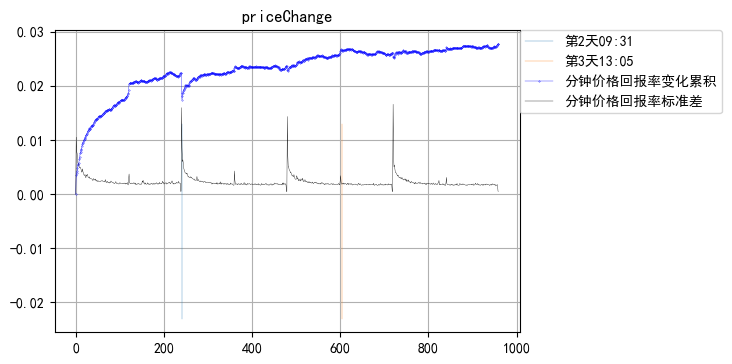

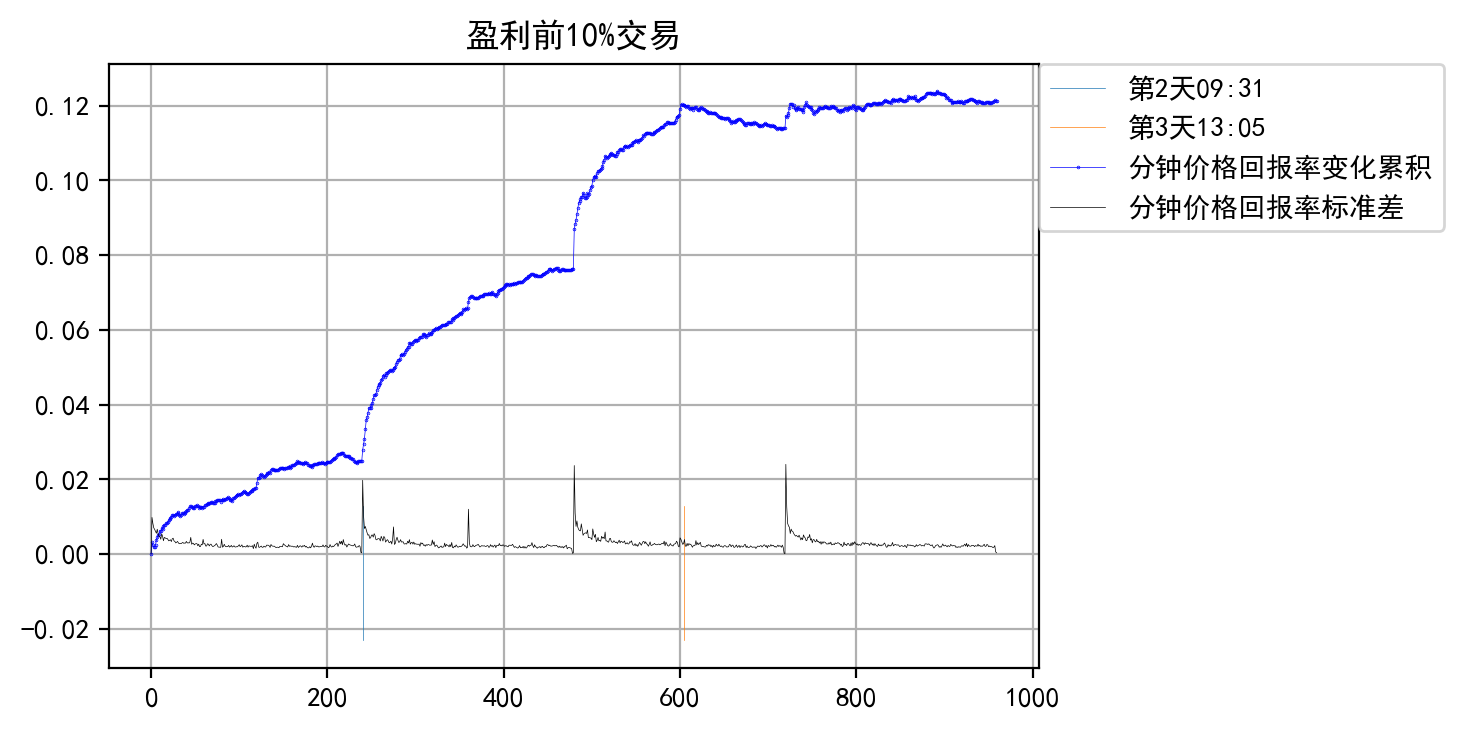

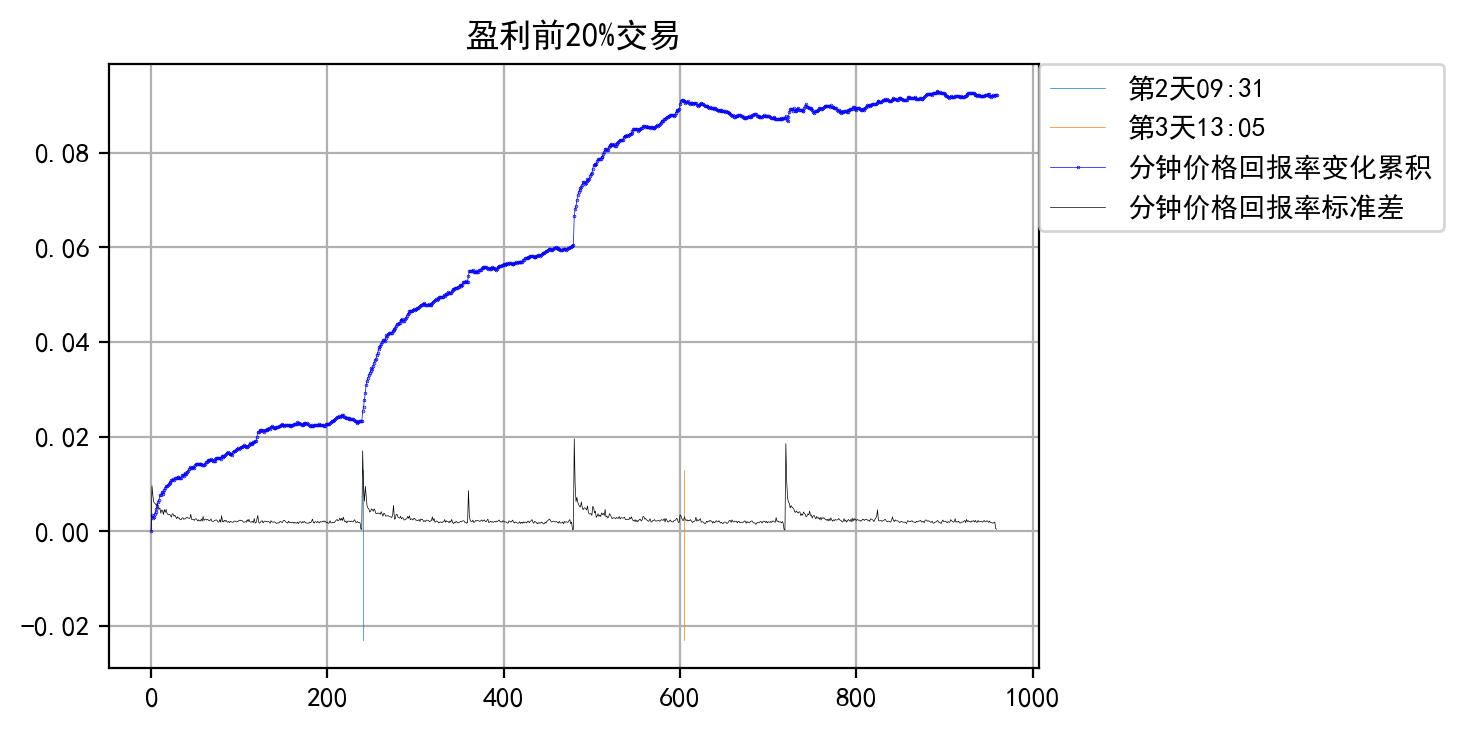

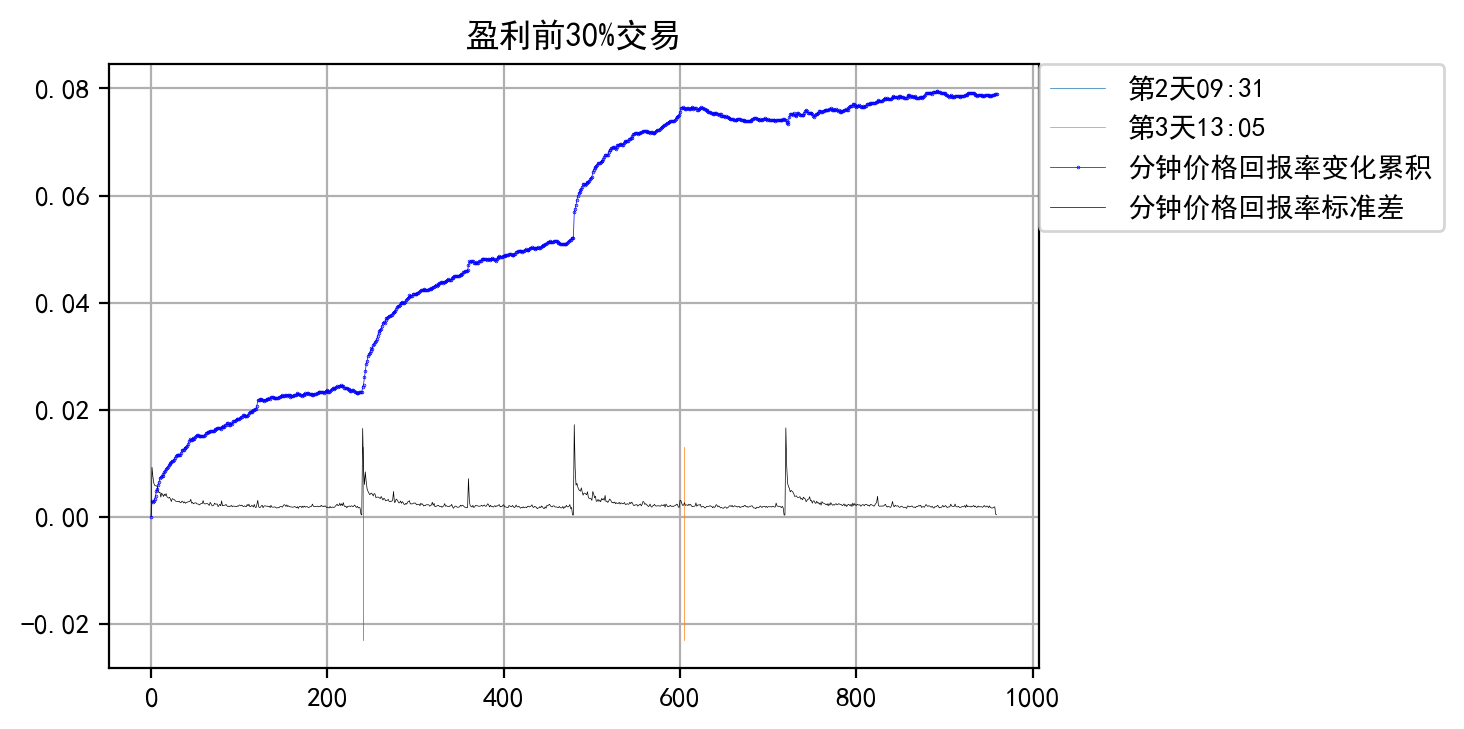

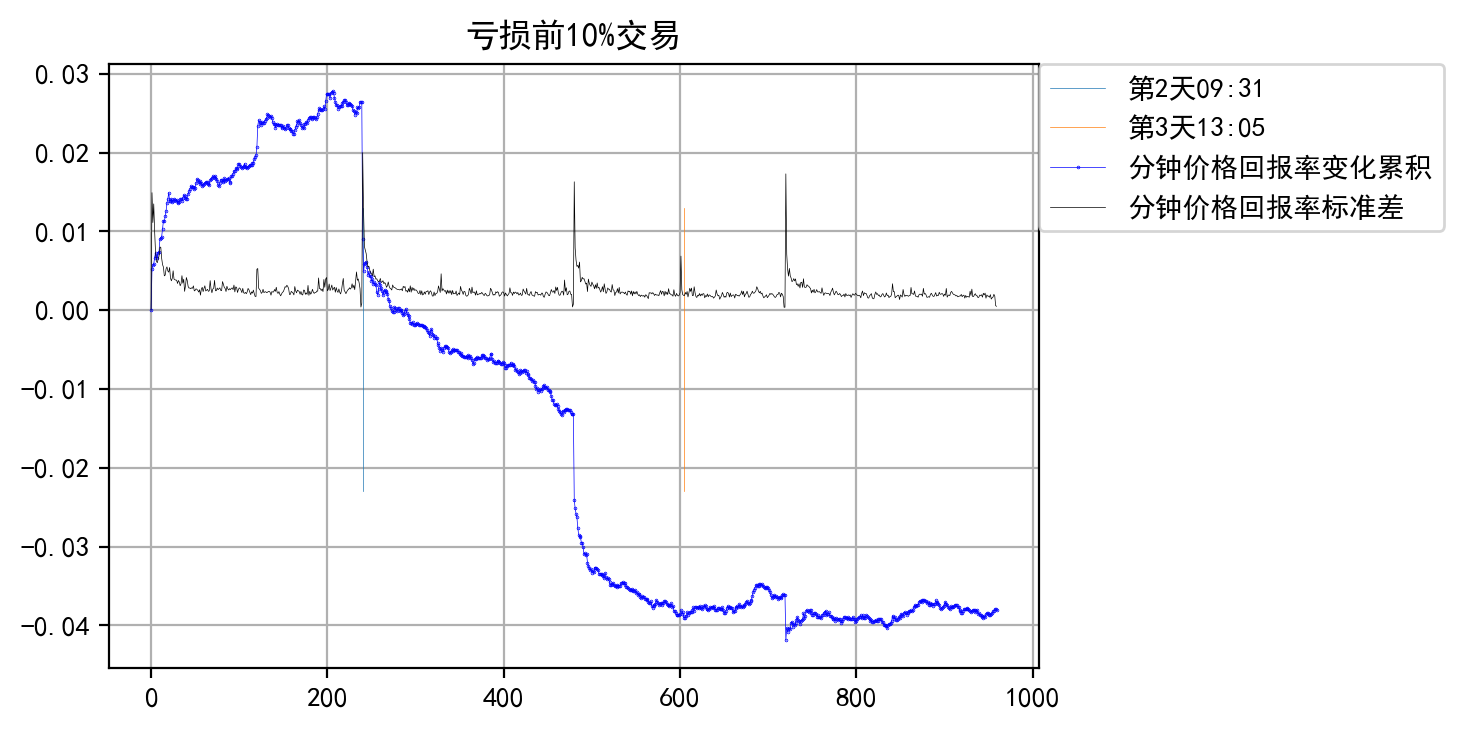

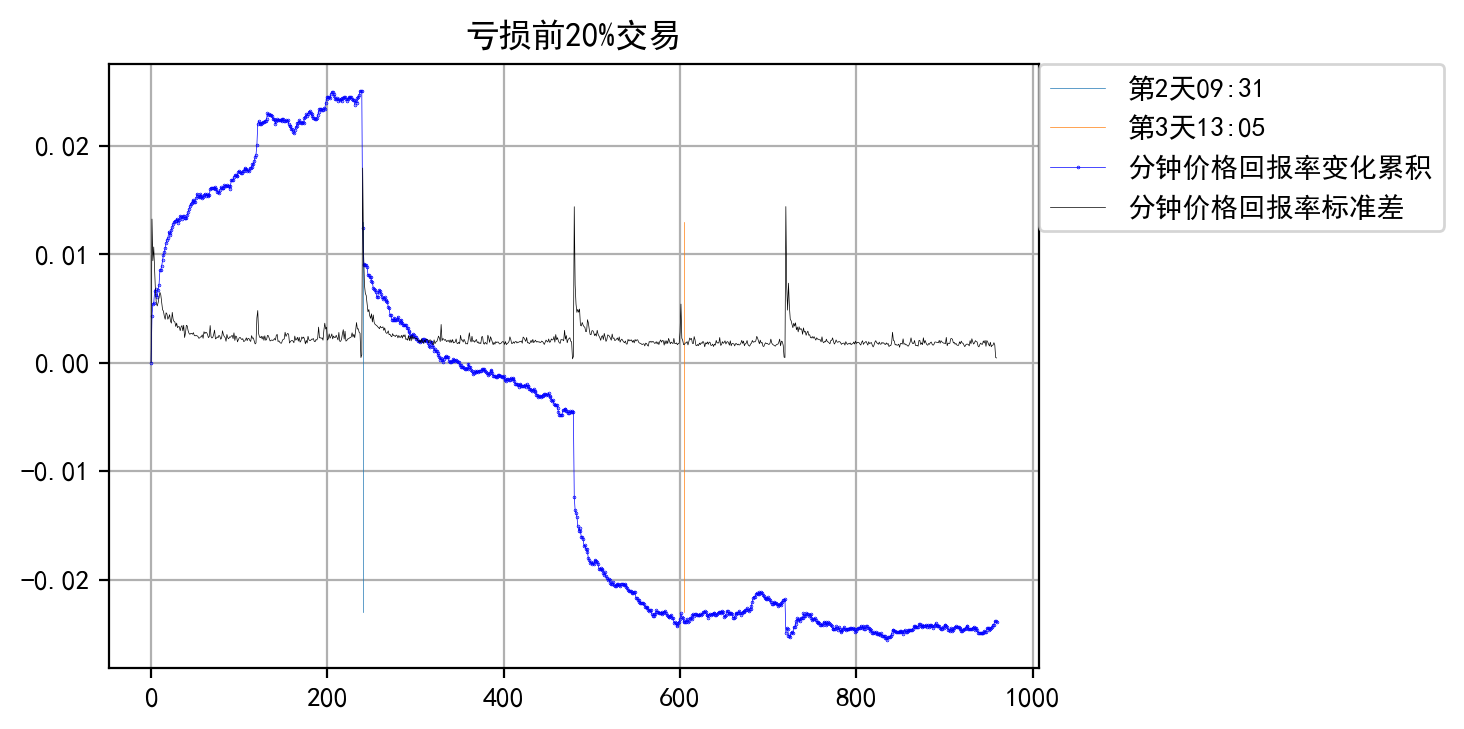

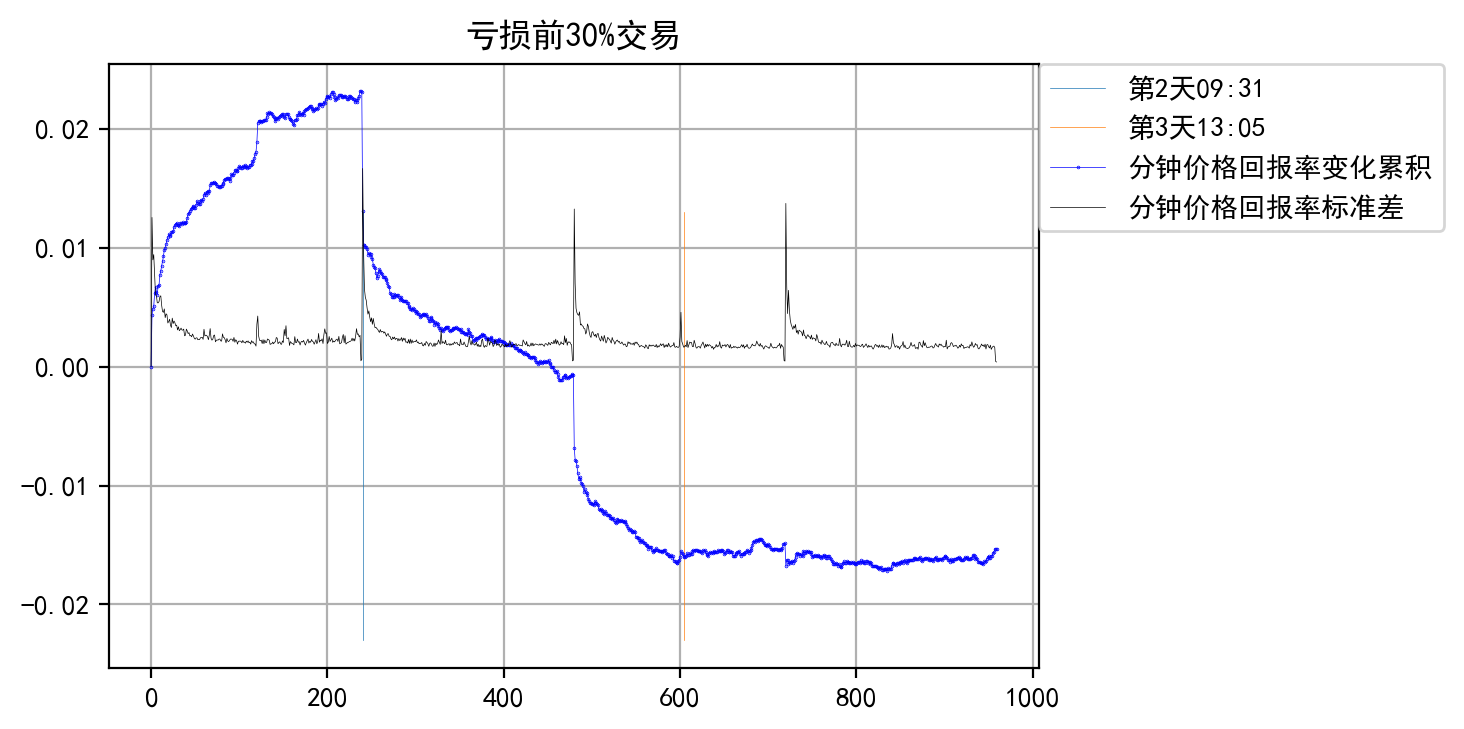

In [37]:
tradeArea=[240,604]
h = np.max(np.cumsum(r[:, :tradeArea[0]], axis=1), axis=1)
isZhangtingBeforeTradeArea = h>=0.05
p = np.sum(r[:, tradeArea[0]:tradeArea[1]], axis=1)
u = np.quantile(p,0.9)
u2 = np.quantile(p,0.8)
u3 = np.quantile(p,0.7)
l = np.quantile(p,0.1)
l2 = np.quantile(p,0.2)
l3 = np.quantile(p,0.3)
rGood = r[p>=u,:]
rGood2 = r[p>=u2,:]
rGood3 = r[p>=u3,:]
rBad = r[p<=l, :]
rBad2 = r[p<=l2, :]
rBad3 = r[p<=l3, :]
#for (i,x) in enumerate(tradesUsed):
#    if p[i]>u:
#        print('good trade:', x['name'], x['dateIn'],p[i],isZhangtingBeforeTradeArea[i])
#    if p[i]<l:
#        print('bad trade:', x['name'], x['dateIn'], p[i],isZhangtingBeforeTradeArea[i])
importlib.reload(rschLib)
rschLib.drawPriceChange(r, strategy_name, timeLabels=timeLabels, tp=tradeArea)
rschLib.drawPriceChange(rGood, strategy_name, timeLabels=timeLabels, title='盈利前10%交易', tp=tradeArea)
rschLib.drawPriceChange(rGood2, strategy_name, timeLabels=timeLabels, title='盈利前20%交易', tp=tradeArea)
rschLib.drawPriceChange(rGood3, strategy_name, timeLabels=timeLabels, title='盈利前30%交易', tp=tradeArea)
rschLib.drawPriceChange(rBad, strategy_name, timeLabels=timeLabels, title='亏损前10%交易', tp=tradeArea)
rschLib.drawPriceChange(rBad2, strategy_name, timeLabels=timeLabels, title='亏损前20%交易', tp=tradeArea)
rschLib.drawPriceChange(rBad3, strategy_name, timeLabels=timeLabels, title='亏损前30%交易', tp=tradeArea)

In [38]:
inTime = 240
otTime = 604

In [39]:
importlib.reload(rschLib)
[dtesPnl,pnl,numTrades]=rschLib.getPnl(dtes,tkrs, name, trades, inTime, otTime, dayOff, timeAsFloat, toDatabase='yes')


{'_id': ObjectId('5d0370cc9d32b03a04f6fb79'), 'ticker': 'SH601919', 'open': 6.99, 'close': 6.99}
{'_id': ObjectId('5d0374be9d32b03a0402eb45'), 'ticker': 'SH601919', 'open': 7.19, 'close': 7.2}
20180103 中远海控 20180104.0931 价 6.99 20180105.1305 价 7.19 利润 2.86 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d03749f9d32b03a04028679'), 'ticker': 'SH601128', 'open': 7.98, 'close': 7.9}
{'_id': ObjectId('5d0378719d32b03a040e7a05'), 'ticker': 'SH601128', 'open': 7.86, 'close': 7.86}
20180104 常熟银行 20180105.0931 价 7.98 20180108.1305 价 7.86 利润 -1.5 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0375399d32b03a04047b19'), 'ticker': 'SZ000009', 'open': 7.65, 'close': 7.56}
{'_id': ObjectId('5d03790a9d32b03a04106db5'), 'ticker': 'SZ000009', 'open': 7.55, 'close': 7.55}
20180104 中国宝安 20180105.0931 价 7.65 20180108.1305 价 7.55 利润 -1.31 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0377929d32b03a040bcc39'), 'ticker': 'SH600093', 'open': 11.43, 'close': 11.43}
{'_id': ObjectId('5d037b579d32b03a0417bde5'), 'ticker': 'SH600093', 'open': 14.0

{'_id': ObjectId('5d03e40b9d32b03a04666049'), 'ticker': 'SH601992', 'open': 5.35, 'close': 5.37}
{'_id': ObjectId('5d03e7ae9d32b03a04721f55'), 'ticker': 'SH601992', 'open': 5.37, 'close': 5.37}
20180222 金隅集团 20180223.0931 价 5.35 20180226.1305 价 5.37 利润 0.37 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d03e3e69d32b03a0465e939'), 'ticker': 'SH601118', 'open': 5.8, 'close': 5.73}
{'_id': ObjectId('5d03e78a9d32b03a0471a845'), 'ticker': 'SH601118', 'open': 5.8, 'close': 5.81}
20180222 海南橡胶 20180223.0931 价 5.8 20180226.1305 价 5.8 利润 0.0 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d03e2f29d32b03a046312a9'), 'ticker': 'SH600008', 'open': 5.0, 'close': 4.97}
{'_id': ObjectId('5d03e6ab9d32b03a046ecfd5'), 'ticker': 'SH600008', 'open': 5.01, 'close': 5.01}
20180222 首创股份 20180223.0931 价 5.0 20180226.1305 价 5.01 利润 0.2 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d03e4d09d32b03a0468c0b9'), 'ticker': 'SZ000735', 'open': 7.69, 'close': 7.67}
{'_id': ObjectId('5d03e86a9d32b03a047480b5'), 'ticker': 'SZ000735', 'open': 8.07, 'close'

{'_id': ObjectId('5d0426799d32b03a0439bc95'), 'ticker': 'SH600635', 'open': 5.36, 'close': 5.37}
20180319 大众公用 20180320.0931 价 5.16 20180321.1305 价 5.36 利润 3.88 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0422469d32b03a042c34f9'), 'ticker': 'SH600053', 'open': 25.54, 'close': 25.49}
{'_id': ObjectId('5d0425f59d32b03a04381115'), 'ticker': 'SH600053', 'open': 27.85, 'close': 27.87}
20180319 九鼎投资 20180320.0931 价 25.54 20180321.1305 价 27.85 利润 9.04 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d04285b9d32b03a043fc8d9'), 'ticker': 'SZ002434', 'open': 9.12, 'close': 9.09}
{'_id': ObjectId('5d042c0d9d32b03a044ba6d5'), 'ticker': 'SZ002434', 'open': 8.96, 'close': 8.96}
20180320 万里扬 20180321.0931 价 9.12 20180322.1305 价 8.96 利润 -1.75 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d042bf89d32b03a044b60f9'), 'ticker': 'SZ002353', 'open': 15.38, 'close': 15.4}
{'_id': ObjectId('5d042fac9d32b03a045740d5'), 'ticker': 'SZ002353', 'open': 14.11, 'close': 14.01}
20180321 杰瑞股份 20180322.0931 价 15.38 20180323.1305 价 14.11 利润 -8.26 % 已经开

{'_id': ObjectId('5d0703b99d32b03ea0372fd0'), 'ticker': 'SZ000060', 'open': 9.6, 'close': 9.6}
{'_id': ObjectId('5d0707d99d32b03ea043181c'), 'ticker': 'SZ000060', 'open': 9.43, 'close': 9.45}
20180419 中金岭南 20180420.0931 价 9.6 20180423.1305 价 9.43 利润 -1.77 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d070a759d32b03ea04b0370'), 'ticker': 'SH600340', 'open': 29.56, 'close': 29.41}
{'_id': ObjectId('5d070e179d32b03ea056f24c'), 'ticker': 'SH600340', 'open': 29.45, 'close': 29.43}
20180423 华夏幸福 20180424.0931 价 29.56 20180425.1305 价 29.45 利润 -0.37 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d070fb79d32b03ea05c3140'), 'ticker': 'SZ000935', 'open': 19.99, 'close': 19.9}
{'_id': ObjectId('5d0713609d32b03ea06826ac'), 'ticker': 'SZ000935', 'open': 20.18, 'close': 20.18}
20180424 四川双马 20180425.0931 价 19.99 20180426.1305 价 20.18 利润 0.95 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d070fff9d32b03ea05d2140'), 'ticker': 'SZ002233', 'open': 11.35, 'close': 11.38}
{'_id': ObjectId('5d0713aa9d32b03ea06916ac'), 'ticker': 'SZ002233', '

{'_id': ObjectId('5d07651f9d32b03ea064f42c'), 'ticker': 'SZ000810', 'open': 8.86, 'close': 8.86}
20180525 创维数字 20180528.0931 价 8.73 20180529.1305 价 8.86 利润 1.49 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d07617a9d32b03ea05a1bc0'), 'ticker': 'SZ002237', 'open': 10.87, 'close': 10.84}
{'_id': ObjectId('5d0765839d32b03ea0663b5c'), 'ticker': 'SZ002237', 'open': 10.43, 'close': 10.44}
20180525 恒邦股份 20180528.0931 价 10.87 20180529.1305 价 10.43 利润 -4.05 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0767d79d32b03ea06de600'), 'ticker': 'SH601018', 'open': 5.22, 'close': 5.16}
{'_id': ObjectId('5d076bc09d32b03ea079fd2c'), 'ticker': 'SH601018', 'open': 5.15, 'close': 5.15}
20180529 宁波港   20180530.0931 价 5.22 20180531.1305 价 5.15 利润 -1.34 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d076f9e9d32b03ea08678a0'), 'ticker': 'SH601801', 'open': 8.84, 'close': 8.78}
{'_id': ObjectId('5d0773379d32b03ea092929c'), 'ticker': 'SH601801', 'open': 8.75, 'close': 8.75}
20180531 皖新传媒 20180601.0931 价 8.84 20180604.1305 价 8.75 利润 -1.02 % 已经开仓 

{'_id': ObjectId('5d07c4819d32b03ea09b5a30'), 'ticker': 'SH600547', 'open': 24.6, 'close': 24.7}
{'_id': ObjectId('5d07c8229d32b03ea0a79d6c'), 'ticker': 'SH600547', 'open': 23.9, 'close': 23.88}
20180704 山东黄金 20180705.0931 价 24.6 20180706.1305 价 23.9 利润 -2.85 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d07c4b89d32b03ea09c14c0'), 'ticker': 'SH600782', 'open': 5.5, 'close': 5.48}
{'_id': ObjectId('5d07c8599d32b03ea0a8570c'), 'ticker': 'SH600782', 'open': 5.49, 'close': 5.49}
20180704 新钢股份 20180705.0931 价 5.5 20180706.1305 价 5.49 利润 -0.18 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d07c5d09d32b03ea09fc890'), 'ticker': 'SZ000761', 'open': 4.0, 'close': 3.98}
{'_id': ObjectId('5d07c9719d32b03ea0ac09ec'), 'ticker': 'SZ000761', 'open': 4.02, 'close': 4.01}
20180704 本钢板材 20180705.0931 价 4.0 20180706.1305 价 4.02 利润 0.5 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d07ccdb9d32b03ea0b79650'), 'ticker': 'SZ000401', 'open': 9.05, 'close': 9.11}
{'_id': ObjectId('5d07d0829d32b03ea0c3e3dc'), 'ticker': 'SZ000401', 'open': 9.86, '

{'_id': ObjectId('5d081d8a9d32b03ea0ca4470'), 'ticker': 'SZ002221', 'open': 9.13, 'close': 9.16}
{'_id': ObjectId('5d08212b9d32b03ea0d6c2bc'), 'ticker': 'SZ002221', 'open': 9.33, 'close': 9.33}
20180807 东华能源 20180808.0931 价 9.13 20180809.1305 价 9.33 利润 2.19 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d081ff59d32b03ea0d29a30'), 'ticker': 'SH601808', 'open': 9.7, 'close': 9.71}
{'_id': ObjectId('5d08239b9d32b03ea0df178c'), 'ticker': 'SH601808', 'open': 10.22, 'close': 10.22}
20180808 中海油服 20180809.0931 价 9.7 20180810.1305 价 10.22 利润 5.36 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d081ff39d32b03ea0d290d0'), 'ticker': 'SH601718', 'open': 4.16, 'close': 4.14}
{'_id': ObjectId('5d0823989d32b03ea0df0e2c'), 'ticker': 'SH601718', 'open': 4.22, 'close': 4.22}
20180808 际华集团 20180809.0931 价 4.16 20180810.1305 价 4.22 利润 1.44 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0823649d32b03ea0de59b0'), 'ticker': 'SH600873', 'open': 4.01, 'close': 4.03}
{'_id': ObjectId('5d0827089d32b03ea0ead7fc'), 'ticker': 'SH600873', 'open': 4.13

{'_id': ObjectId('5d089ceb9d32b02cfc5f5166'), 'ticker': 'SZ002594', 'open': 44.0, 'close': 43.61}
{'_id': ObjectId('5d09683b9d32b02ca853160c'), 'ticker': 'SZ002594', 'open': 44.4, 'close': 44.48}
20180914 比亚迪 20180917.0931 价 44.0 20180918.1305 价 44.4 利润 0.91 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0970679d32b02ca86beac0'), 'ticker': 'SZ002468', 'open': 17.29, 'close': 17.29}
{'_id': ObjectId('5d0974919d32b02ca878924c'), 'ticker': 'SZ002468', 'open': 18.35, 'close': 18.39}
20180919 申通快递 20180920.0931 价 17.29 20180921.1305 价 18.35 利润 6.13 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d096f8d9d32b02ca86957b0'), 'ticker': 'SZ000629', 'open': 3.6, 'close': 3.61}
{'_id': ObjectId('5d0973b59d32b02ca875ff3c'), 'ticker': 'SZ000629', 'open': 3.66, 'close': 3.66}
20180919 攀钢钒钛 20180920.0931 价 3.6 20180921.1305 价 3.66 利润 1.67 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d096fd99d32b02ca86a3a90'), 'ticker': 'SZ000987', 'open': 7.06, 'close': 7.12}
{'_id': ObjectId('5d0974009d32b02ca876e21c'), 'ticker': 'SZ000987', 'open': 

{'_id': ObjectId('5d09e2619d32b02ca89c3d00'), 'ticker': 'SZ002180', 'open': 25.0, 'close': 25.18}
{'_id': ObjectId('5d09e85c9d32b02ca8a8fecc'), 'ticker': 'SZ002180', 'open': 25.39, 'close': 25.39}
20181031 纳思达 20181101.0931 价 25.0 20181102.1305 价 25.39 利润 1.56 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d09e1089d32b02ca898fe60'), 'ticker': 'SH603369', 'open': 14.77, 'close': 14.66}
{'_id': ObjectId('5d09e6cf9d32b02ca8a5be4c'), 'ticker': 'SH603369', 'open': 15.3, 'close': 15.32}
20181031 今世缘   20181101.0931 价 14.77 20181102.1305 价 15.3 利润 3.59 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d09e1fd9d32b02ca89b4d00'), 'ticker': 'SZ000895', 'open': 21.61, 'close': 21.7}
{'_id': ObjectId('5d09e7eb9d32b02ca8a80ecc'), 'ticker': 'SZ000895', 'open': 22.5, 'close': 22.52}
20181031 双汇发展 20181101.0931 价 21.61 20181102.1305 价 22.5 利润 4.12 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d09e1f19d32b02ca89b20f0'), 'ticker': 'SZ000818', 'open': 9.19, 'close': 9.19}
{'_id': ObjectId('5d09e7d49d32b02ca8a7e2bc'), 'ticker': 'SZ000818', 'o

{'_id': ObjectId('5d0a37429d32b02ca88c4ed0'), 'ticker': 'SH601933', 'open': 7.25, 'close': 7.25}
{'_id': ObjectId('5d0a3b279d32b02ca8993e8c'), 'ticker': 'SH601933', 'open': 7.27, 'close': 7.28}
20181127 永辉超市 20181128.0931 价 7.25 20181129.1305 价 7.27 利润 0.28 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0a373a9d32b02ca88c3490'), 'ticker': 'SH601801', 'open': 6.98, 'close': 7.04}
{'_id': ObjectId('5d0a3b1f9d32b02ca899244c'), 'ticker': 'SH601801', 'open': 6.89, 'close': 6.88}
20181127 皖新传媒 20181128.0931 价 6.98 20181129.1305 价 6.89 利润 -1.29 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0a3c429d32b02ca89cd5c0'), 'ticker': 'SZ002056', 'open': 6.14, 'close': 6.05}
{'_id': ObjectId('5d0a40229d32b02ca8a9c57c'), 'ticker': 'SZ002056', 'open': 5.87, 'close': 5.87}
20181128 横店东磁 20181129.0931 价 6.14 20181130.1305 价 5.87 利润 -4.4 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0a3cdb9d32b02ca89ed4b0'), 'ticker': 'SZ002608', 'open': 7.77, 'close': 7.72}
{'_id': ObjectId('5d0a40b99d32b02ca8abc46c'), 'ticker': 'SZ002608', 'open': 7.48

{'_id': ObjectId('5d0b39da9d32b04d04a323be'), 'ticker': 'SZ300450', 'open': 29.42, 'close': 29.38}
{'_id': ObjectId('5d0b3dda9d32b04d04b0263a'), 'ticker': 'SZ300450', 'open': 29.19, 'close': 29.19}
20181227 先导智能 20181228.0931 价 29.42 20190102.1305 价 29.19 利润 -0.78 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0b49689d32b04d04b7803e'), 'ticker': 'SZ000735', 'open': 10.05, 'close': 10.05}
{'_id': ObjectId('5d0b4f3e9d32b04d04c4849a'), 'ticker': 'SZ000735', 'open': 11.31, 'close': 11.31}
20190102 罗 牛 山 20190103.0931 价 10.05 20190104.1305 价 11.31 利润 12.54 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0b505b9d32b04d04c6ffbe'), 'ticker': 'SZ002498', 'open': 2.04, 'close': 2.05}
{'_id': ObjectId('5d0b56309d32b04d04d4041a'), 'ticker': 'SZ002498', 'open': 2.5, 'close': 2.5}
20190103 汉缆股份 20190104.0931 价 2.04 20190107.1305 价 2.5 利润 22.55 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d0b532b9d32b04d04cd43ce'), 'ticker': 'SH600673', 'open': 7.58, 'close': 7.52}
{'_id': ObjectId('5d0b58fd9d32b04d04da473a'), 'ticker': 'SH600673', 

{'_id': ObjectId('5d11aed89d32b00950c81eeb'), 'ticker': 'SZ300033', 'open': 46.28, 'close': 46.46}
{'_id': ObjectId('5d11b8739d32b00950d53247'), 'ticker': 'SZ300033', 'open': 52.34, 'close': 52.28}
20190211 同花顺 20190212.0931 价 46.28 20190213.1305 价 52.34 利润 13.09 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d11a9629d32b00950c208cb'), 'ticker': 'SH603456', 'open': 6.88, 'close': 6.82}
{'_id': ObjectId('5d11b5369d32b00950cf1c27'), 'ticker': 'SH603456', 'open': 7.1, 'close': 7.1}
20190211 九洲药业 20190212.0931 价 6.88 20190213.1305 价 7.1 利润 3.2 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d11a6609d32b00950be3f6b'), 'ticker': 'SH600201', 'open': 15.96, 'close': 15.91}
{'_id': ObjectId('5d11b1e29d32b00950cb52c7'), 'ticker': 'SH600201', 'open': 16.0, 'close': 16.01}
20190211 生物股份 20190212.0931 价 15.96 20190213.1305 价 16.0 利润 0.25 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d11abe09d32b00950c4fb7b'), 'ticker': 'SZ002099', 'open': 4.72, 'close': 4.74}
{'_id': ObjectId('5d11b7229d32b00950d20ed7'), 'ticker': 'SZ002099', 'open':

{'_id': ObjectId('5d11f34d9d32b009505d94a7'), 'ticker': 'SH601099', 'open': 3.98, 'close': 3.98}
20190226 太平洋   20190227.0931 价 3.83 20190228.1305 价 3.98 利润 3.92 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d11ec309d32b009504fa04b'), 'ticker': 'SH600717', 'open': 8.29, 'close': 8.29}
{'_id': ObjectId('5d11f2d79d32b009505cb1c7'), 'ticker': 'SH600717', 'open': 8.3, 'close': 8.29}
20190226 天津港   20190227.0931 价 8.29 20190228.1305 价 8.3 利润 0.12 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d11eb519d32b009504e0f0b'), 'ticker': 'SH600196', 'open': 28.21, 'close': 28.2}
{'_id': ObjectId('5d11f21d9d32b009505b2087'), 'ticker': 'SH600196', 'open': 29.16, 'close': 29.18}
20190226 复星医药 20190227.0931 价 28.21 20190228.1305 价 29.16 利润 3.37 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d11f2bb9d32b009505c6afb'), 'ticker': 'SH600633', 'open': 11.25, 'close': 11.42}
{'_id': ObjectId('5d11f8ea9d32b00950697e57'), 'ticker': 'SH600633', 'open': 10.74, 'close': 10.73}
20190227 浙数文化 20190228.0931 价 11.25 20190301.1305 价 10.74 利润 -4.53 % 已经开

{'_id': ObjectId('5d127d169d32b009507db97b'), 'ticker': 'SH601989', 'open': 5.99, 'close': 6.04}
{'_id': ObjectId('5d1283e29d32b009508acdc7'), 'ticker': 'SH601989', 'open': 6.65, 'close': 6.64}
20190329 中国重工 20190401.0931 价 5.99 20190402.1305 价 6.65 利润 11.02 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d1288ad9d32b0095093c53b'), 'ticker': 'SZ300618', 'open': 90.0, 'close': 90.48}
{'_id': ObjectId('5d128f939d32b00950a0d4d7'), 'ticker': 'SZ300618', 'open': 101.12, 'close': 102.09}
20190401 寒锐钴业 20190402.0931 价 90.0 20190403.1305 价 101.12 利润 12.36 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d12829b9d32b00950884deb'), 'ticker': 'SH600362', 'open': 16.66, 'close': 16.59}
{'_id': ObjectId('5d1289859d32b00950956507'), 'ticker': 'SH600362', 'open': 16.47, 'close': 16.48}
20190401 江西铜业 20190402.0931 价 16.66 20190403.1305 价 16.47 利润 -1.14 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d12824d9d32b0095087b8db'), 'ticker': 'SH600176', 'open': 11.4, 'close': 11.44}
{'_id': ObjectId('5d1289339d32b0095094cff7'), 'ticker': 'SH60017

{'_id': ObjectId('5d1326dd9d32b0386c74cad0'), 'ticker': 'SH600546', 'open': 5.0, 'close': 4.98}
{'_id': ObjectId('5d132b779d32b0386c81ed2c'), 'ticker': 'SH600546', 'open': 4.96, 'close': 4.96}
20190515 山煤国际 20190516.0931 价 5.0 20190517.1305 价 4.96 利润 -0.8 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d132bf89d32b0386c836860'), 'ticker': 'SH601118', 'open': 5.29, 'close': 5.27}
{'_id': ObjectId('5d1330699d32b0386c908d8c'), 'ticker': 'SH601118', 'open': 5.28, 'close': 5.28}
20190516 海南橡胶 20190517.0931 价 5.29 20190520.1305 价 5.28 利润 -0.19 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d132cca9d32b0386c85e6d0'), 'ticker': 'SZ000158', 'open': 6.07, 'close': 6.07}
{'_id': ObjectId('5d1331499d32b0386c930b0c'), 'ticker': 'SZ000158', 'open': 5.91, 'close': 5.92}
20190516 常山北明 20190517.0931 价 6.07 20190520.1305 价 5.91 利润 -2.64 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d1331659d32b0386c9350e0'), 'ticker': 'SZ000555', 'open': 11.92, 'close': 11.78}
{'_id': ObjectId('5d1335e19d32b0386ca0760c'), 'ticker': 'SZ000555', 'open': 11.

{'_id': ObjectId('5d139bf09d32b0386cd8772c'), 'ticker': 'SH600583', 'open': 5.6, 'close': 5.59}
20190621 海油工程 20190624.0931 价 5.66 20190625.1305 价 5.6 利润 -1.06 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d139a689d32b0386cd42b00'), 'ticker': 'SZ300058', 'open': 4.4, 'close': 4.39}
{'_id': ObjectId('5d139f219d32b0386ce15e3c'), 'ticker': 'SZ300058', 'open': 4.24, 'close': 4.24}
20190621 蓝色光标 20190624.0931 价 4.4 20190625.1305 价 4.24 利润 -3.64 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d1398a29d32b0386ccf2e20'), 'ticker': 'SZ000410', 'open': 7.24, 'close': 7.17}
{'_id': ObjectId('5d139d549d32b0386cdc633c'), 'ticker': 'SZ000410', 'open': 6.96, 'close': 6.97}
20190621 *ST沈机 20190624.0931 价 7.24 20190625.1305 价 6.96 利润 -3.87 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d139a8c9d32b0386cd48e60'), 'ticker': 'SZ300166', 'open': 12.68, 'close': 12.65}
{'_id': ObjectId('5d139f419d32b0386ce1c19c'), 'ticker': 'SZ300166', 'open': 12.38, 'close': 12.39}
20190621 东方国信 20190624.0931 价 12.68 20190625.1305 价 12.38 利润 -2.37 % 已经开仓 1 已

{'_id': ObjectId('5d4931c1e23f1d46345af3d3'), 'ticker': 'SH600111', 'open': 12.18, 'close': 12.19}
20190802 北方稀土 20190805.0931 价 12.08 20190806.1305 价 12.18 利润 0.83 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d483176e23f1d2d5c4fd028'), 'ticker': 'SH600483', 'open': 8.46, 'close': 8.44}
{'_id': ObjectId('5d493213e23f1d46345c0c23'), 'ticker': 'SH600483', 'open': 7.96, 'close': 7.96}
20190802 福能股份 20190805.0931 价 8.46 20190806.1305 价 7.96 利润 -5.91 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d4832cbe23f1d2d5c556129'), 'ticker': 'SZ000970', 'open': 10.7, 'close': 10.6}
{'_id': ObjectId('5d4933f8e23f1d4634619e14'), 'ticker': 'SZ000970', 'open': 10.5, 'close': 10.5}
20190802 中科三环 20190805.0931 价 10.7 20190806.1305 价 10.5 利润 -1.87 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d48316ae23f1d2d5c4f9ab8'), 'ticker': 'SH600392', 'open': 10.18, 'close': 10.14}
{'_id': ObjectId('5d493203e23f1d46345bd6b3'), 'ticker': 'SH600392', 'open': 10.1, 'close': 10.1}
20190802 盛和资源 20190805.0931 价 10.18 20190806.1305 价 10.1 利润 -0.79 % 已经开仓 

{'_id': ObjectId('5d75fa30e23f1d73fc971bf4'), 'ticker': 'SH600958', 'open': 10.72, 'close': 10.72}
20190905 东方证券 20190906.0931 价 10.65 20190909.1305 价 10.72 利润 0.66 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d720651e23f1d697c5f4c30'), 'ticker': 'SH601788', 'open': 11.71, 'close': 11.78}
{'_id': ObjectId('5d75fa5ae23f1d73fc97bd34'), 'ticker': 'SH601788', 'open': 11.92, 'close': 11.94}
20190905 光大证券 20190906.0931 价 11.71 20190909.1305 价 11.92 利润 1.79 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d7205e0e23f1d697c5dc450'), 'ticker': 'SH600643', 'open': 9.39, 'close': 9.39}
{'_id': ObjectId('5d75f9f3e23f1d73fc963554'), 'ticker': 'SH600643', 'open': 9.38, 'close': 9.38}
20190905 爱建集团 20190906.0931 价 9.39 20190909.1305 价 9.38 利润 -0.11 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5d774d49e23f1d0180d0458d'), 'ticker': 'SZ000725', 'open': 4.14, 'close': 4.12}
{'_id': ObjectId('5d789e9ce23f1d9e6cbe57dc'), 'ticker': 'SZ000725', 'open': 4.12, 'close': 4.12}
20190909 京东方Ａ 20190910.0931 价 4.14 20190911.1305 价 4.12 利润 -0.48 % 已经开

{'_id': ObjectId('5dc11ed634b93e2338a39940'), 'ticker': 'SH601607', 'open': 19.27, 'close': 19.19}
{'_id': ObjectId('5dc270c434b93e30b4515eff'), 'ticker': 'SH601607', 'open': 18.74, 'close': 18.74}
20191104 上海医药 20191105.0931 价 19.27 20191106.1305 价 18.74 利润 -2.75 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5dc272c634b93e30b459202c'), 'ticker': 'SZ300168', 'open': 15.96, 'close': 16.14}
{'_id': ObjectId('5dc3c44f34b93e1ea064c2dc'), 'ticker': 'SZ300168', 'open': 18.7, 'close': 18.7}
20191105 万达信息 20191106.0931 价 15.96 20191107.1305 价 18.7 利润 17.17 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5dc3c21334b93e1ea05bf2b8'), 'ticker': 'SH600760', 'open': 29.92, 'close': 29.66}
{'_id': ObjectId('5dc5134f34b93e35304ff891'), 'ticker': 'SH600760', 'open': 29.2, 'close': 29.18}
20191106 中航沈飞 20191107.0931 价 29.92 20191108.1305 价 29.2 利润 -2.41 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5dc5144a34b93e3530543e27'), 'ticker': 'SZ000800', 'open': 8.93, 'close': 8.96}
{'_id': ObjectId('5dc908ce34b93e252c1b0fbb'), 'ticker': 'SZ000800

{'_id': ObjectId('5e0ee7c934b93e0cd0e86bca'), 'ticker': 'SH601336', 'open': 51.0, 'close': 51.46}
{'_id': ObjectId('5e12dbc434b93e4120f99433'), 'ticker': 'SH601336', 'open': 51.05, 'close': 51.03}
20200102 新华保险 20200103.0931 价 51.0 20200106.1305 价 51.05 利润 0.1 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e0ee8e534b93e0cd0ec910b'), 'ticker': 'SZ002075', 'open': 6.35, 'close': 6.38}
{'_id': ObjectId('5e12dcb434b93e4120fdb885'), 'ticker': 'SZ002075', 'open': 6.42, 'close': 6.41}
20200102 沙钢股份 20200103.0931 价 6.35 20200106.1305 价 6.42 利润 1.1 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e12db5034b93e4120f792e7'), 'ticker': 'SH600415', 'open': 4.1, 'close': 4.05}
{'_id': ObjectId('5e142deb34b93e59cc2c222d'), 'ticker': 'SH600415', 'open': 4.09, 'close': 4.07}
20200103 小商品城 20200106.0931 价 4.1 20200107.1305 价 4.09 利润 -0.24 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e142f1634b93e59cc313602'), 'ticker': 'SZ000690', 'open': 6.12, 'close': 6.17}
{'_id': ObjectId('5e15805234b93e5a9867f52d'), 'ticker': 'SZ000690', 'open': 6.48

{'_id': ObjectId('5e4cde1a34b93e986cd97e90'), 'ticker': 'SH600803', 'open': 10.53, 'close': 10.48}
{'_id': ObjectId('5e4e2f8334b93e26fc79d149'), 'ticker': 'SH600803', 'open': 10.49, 'close': 10.48}
20200218 新奥股份 20200219.0931 价 10.53 20200220.1305 价 10.49 利润 -0.38 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e4cddb434b93e986cd7d5e0'), 'ticker': 'SH600259', 'open': 33.5, 'close': 33.12}
{'_id': ObjectId('5e4e2f1c34b93e26fc782899'), 'ticker': 'SH600259', 'open': 32.34, 'close': 32.38}
20200218 广晟有色 20200219.0931 价 33.5 20200220.1305 价 32.34 利润 -3.46 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e4f80e934b93e92b017f9c3'), 'ticker': 'SH601118', 'open': 4.56, 'close': 4.52}
{'_id': ObjectId('5e53765e34b93e64fcc0e111'), 'ticker': 'SH601118', 'open': 4.51, 'close': 4.51}
20200220 海南橡胶 20200221.0931 价 4.56 20200224.1305 价 4.51 利润 -1.1 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e4f818934b93e92b01aa8f4'), 'ticker': 'SZ000415', 'open': 3.6, 'close': 3.56}
{'_id': ObjectId('5e53770834b93e64fcc39132'), 'ticker': 'SZ000415', 'o

{'_id': ObjectId('5e8199ee34b93e2418fb8fd3'), 'ticker': 'SH601018', 'open': 3.8, 'close': 3.54}
{'_id': ObjectId('5e82ebbc34b93ee578bab959'), 'ticker': 'SH601018', 'open': 3.52, 'close': 3.54}
20200327 宁波港   20200330.0931 价 3.8 20200331.1305 价 3.52 利润 -7.37 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e82eb7c34b93ee578b9ec7d'), 'ticker': 'SH600729', 'open': 27.75, 'close': 27.75}
{'_id': ObjectId('5e843e6834b93e61a4d2f930'), 'ticker': 'SH600729', 'open': 27.54, 'close': 27.56}
20200330 重庆百货 20200331.0931 价 27.75 20200401.1305 价 27.54 利润 -0.76 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e84400134b93e61a4d7b307'), 'ticker': 'SZ000921', 'open': 9.49, 'close': 9.4}
{'_id': ObjectId('5e85908a34b93e2f589a66e2'), 'ticker': 'SZ000921', 'open': 9.07, 'close': 9.07}
20200331 海信家电 20200401.0931 价 9.49 20200402.1305 价 9.07 利润 -4.43 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5e843df834b93e61a4d1b634'), 'ticker': 'SH600309', 'open': 41.5, 'close': 41.36}
{'_id': ObjectId('5e858ee234b93e2f58946a0f'), 'ticker': 'SH600309', 'open

{'_id': ObjectId('5eaa7abb34b93e86d43ee2a2'), 'ticker': 'SH600548', 'open': 9.53, 'close': 9.6}
{'_id': ObjectId('5eb2611934b93eb3449fb610'), 'ticker': 'SH600548', 'open': 9.52, 'close': 9.51}
20200429 深高速   20200430.0931 价 9.53 20200506.1305 价 9.52 利润 -0.1 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5eaa7cd434b93e86d44581b0'), 'ticker': 'SZ002304', 'open': 99.0, 'close': 98.5}
{'_id': ObjectId('5eb262c734b93eb344a65ba7'), 'ticker': 'SZ002304', 'open': 99.57, 'close': 99.55}
20200429 洋河股份 20200430.0931 价 99.0 20200506.1305 价 99.57 利润 0.58 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5eaa7c1734b93e86d4433f35'), 'ticker': 'SZ000538', 'open': 92.1, 'close': 92.02}
{'_id': ObjectId('5eb2623534b93eb344a41392'), 'ticker': 'SZ000538', 'open': 90.17, 'close': 90.16}
20200429 云南白药 20200430.0931 价 92.1 20200506.1305 价 90.17 利润 -2.1 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5eaa7b2f34b93e86d4406302'), 'ticker': 'SH601155', 'open': 32.39, 'close': 32.3}
{'_id': ObjectId('5eb2617b34b93eb344a13670'), 'ticker': 'SH601155', 'open

20200527 吉祥航空 20200528.0931 价 9.07 20200529.1305 价 9.04 利润 -0.33 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5ed0b4a234b93e2c388e2834'), 'ticker': 'SZ000539', 'open': 3.67, 'close': 3.75}
{'_id': ObjectId('5ed4a93634b93e29700faabb'), 'ticker': 'SZ000539', 'open': 3.76, 'close': 3.75}
20200528 粤电力Ａ 20200529.0931 价 3.67 20200601.1305 价 3.76 利润 2.45 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5ed4a82f34b93e29700b921d'), 'ticker': 'SH600637', 'open': 10.11, 'close': 10.02}
{'_id': ObjectId('5ed5f9a934b93e85d081eac7'), 'ticker': 'SH600637', 'open': 10.03, 'close': 10.03}
20200529 东方明珠 20200601.0931 价 10.11 20200602.1305 价 10.03 利润 -0.79 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5ed4a86934b93e29700c7b8d'), 'ticker': 'SH600959', 'open': 3.7, 'close': 3.64}
{'_id': ObjectId('5ed5f9e034b93e85d082d437'), 'ticker': 'SH600959', 'open': 3.69, 'close': 3.69}
20200529 江苏有线 20200601.0931 价 3.7 20200602.1305 价 3.69 利润 -0.27 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5ed4a86234b93e29700c614d'), 'ticker': 'SH600884', 'open': 11.55, 'close':

{'_id': ObjectId('5f02cdec34b93e0180e25440'), 'ticker': 'SH601669', 'open': 3.86, 'close': 3.9}
{'_id': ObjectId('5f041f6234b93e62cc7d0c6e'), 'ticker': 'SH601669', 'open': 4.44, 'close': 4.43}
20200703 中国电建 20200706.0931 价 3.86 20200707.1305 价 4.44 利润 15.03 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f02cdba34b93e0180e1bb7f'), 'ticker': 'SH600958', 'open': 11.67, 'close': 11.74}
{'_id': ObjectId('5f041f3434b93e62cc7c739e'), 'ticker': 'SH600958', 'open': 12.28, 'close': 12.27}
20200703 东方证券 20200706.0931 价 11.67 20200707.1305 价 12.28 利润 5.23 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f02cd1f34b93e0180e05fb0'), 'ticker': 'SH600497', 'open': 3.78, 'close': 3.79}
{'_id': ObjectId('5f041eca34b93e62cc7b16de'), 'ticker': 'SH600497', 'open': 4.02, 'close': 4.01}
20200703 驰宏锌锗 20200706.0931 价 3.78 20200707.1305 价 4.02 利润 6.35 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f02cddc34b93e0180e22bff'), 'ticker': 'SH601336', 'open': 52.05, 'close': 52.72}
{'_id': ObjectId('5f041f5534b93e62cc7ce41e'), 'ticker': 'SH601336', 'open

{'_id': ObjectId('5f3205f434b93e276cf16b5d'), 'ticker': 'SZ300618', 'open': 74.1, 'close': 74.56}
{'_id': ObjectId('5f320ac334b93e276cff2599'), 'ticker': 'SZ300618', 'open': 76.1, 'close': 76.23}
20200728 寒锐钴业 20200729.0931 价 74.1 20200730.1305 价 76.1 利润 2.7 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f32053834b93e276cef4d7d'), 'ticker': 'SZ300027', 'open': 4.71, 'close': 4.67}
{'_id': ObjectId('5f320a0b34b93e276cfd07b9'), 'ticker': 'SZ300027', 'open': 4.87, 'close': 4.87}
20200728 华谊兄弟 20200729.0931 价 4.71 20200730.1305 价 4.87 利润 3.4 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f32065534b93e276cf280dd'), 'ticker': 'SH600093', 'open': 14.22, 'close': 14.22}
{'_id': ObjectId('5f320b2834b93e276c003b19'), 'ticker': 'SH600093', 'open': 13.59, 'close': 13.58}
20200729 易见股份 20200730.0931 价 14.22 20200731.1305 价 13.59 利润 -4.43 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f32071934b93e276cf4b53d'), 'ticker': 'SH600816', 'open': 2.02, 'close': 2.02}
{'_id': ObjectId('5f320bd834b93e276c026f79'), 'ticker': 'SH600816', 'open'

{'_id': ObjectId('5f62d78534b93e32c00a9abf'), 'ticker': 'SZ000413', 'open': 3.21, 'close': 3.22}
{'_id': ObjectId('5f63369c34b93e82107b1236'), 'ticker': 'SZ000413', 'open': 3.22, 'close': 3.22}
20200915 东旭光电 20200916.0931 价 3.21 20200917.1305 价 3.22 利润 0.31 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f6d682b34b93e5364c2a949'), 'ticker': 'SH600548', 'open': 9.07, 'close': 9.02}
{'_id': ObjectId('5f6d6c4734b93e5364d09cb5'), 'ticker': 'SH600548', 'open': 8.9, 'close': 8.9}
20200918 深高速   20200921.0931 价 9.07 20200922.1305 价 8.9 利润 -1.87 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f6d6eb934b93e5364d8b7d9'), 'ticker': 'SZ002670', 'open': 9.84, 'close': 9.99}
{'_id': ObjectId('5f6d730734b93e5364e6ae15'), 'ticker': 'SZ002670', 'open': 10.28, 'close': 10.29}
20200921 国盛金控 20200922.0931 价 9.84 20200923.1305 价 10.28 利润 4.47 % 已经开仓 1 已经平仓 1
{'_id': ObjectId('5f6d6d9234b93e5364d4d9d9'), 'ticker': 'SZ000088', 'open': 6.75, 'close': 6.75}
{'_id': ObjectId('5f6d71d834b93e5364e2d1f5'), 'ticker': 'SZ000088', 'open': 7.2

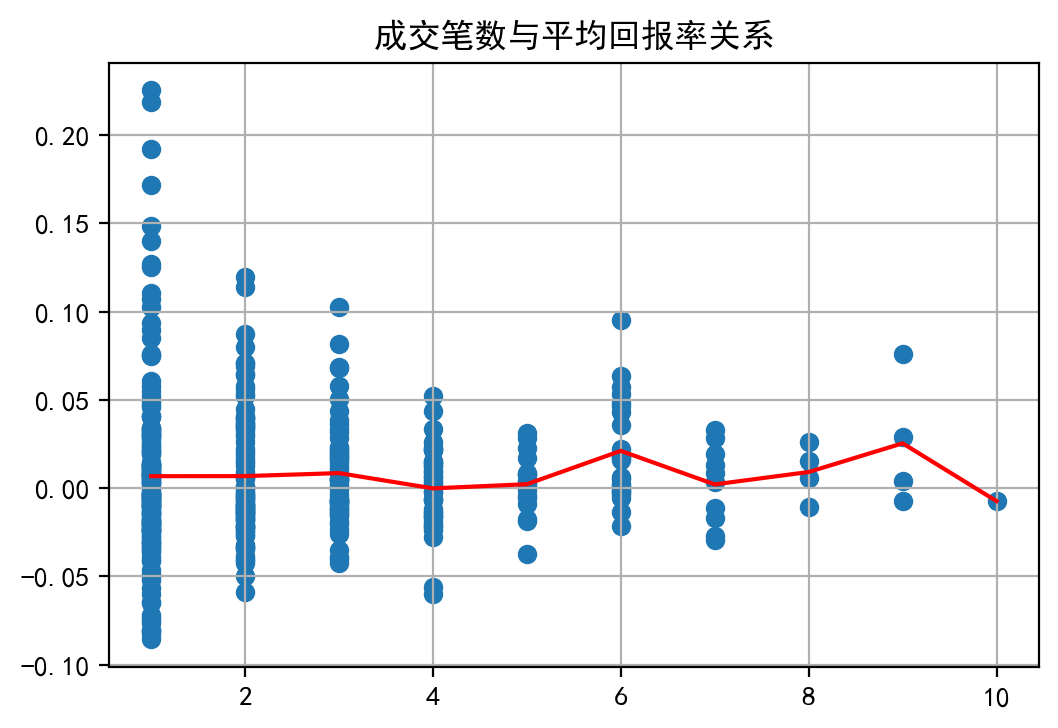

In [40]:
importlib.reload(rschLib)
rschLib.pnlVsNumtrades(pnl, numTrades)

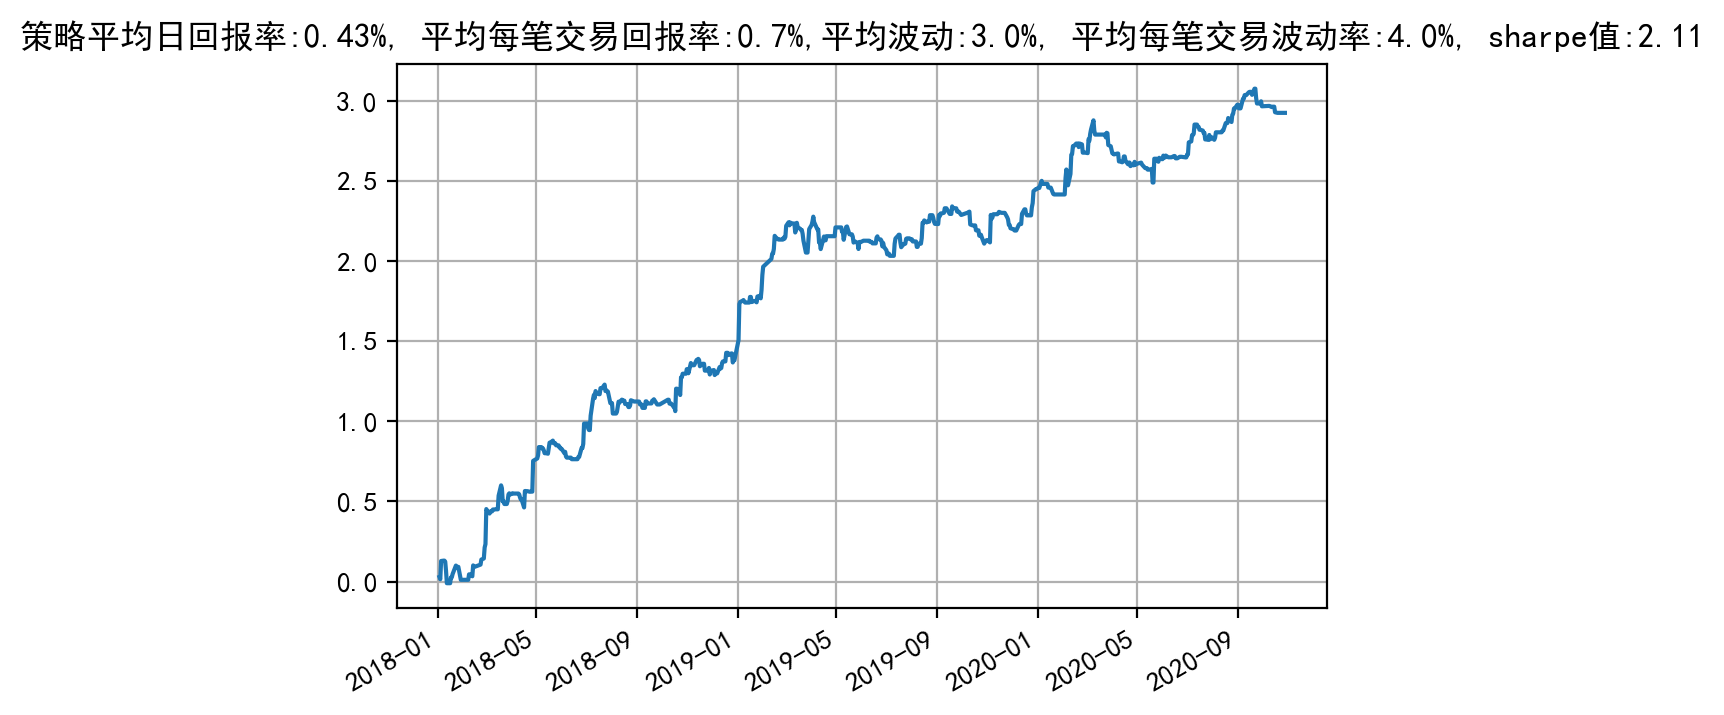

In [41]:
rschLib.drawPNL(dtesPnl, pnl, dtes, strategy_name, toDatabase='yes')

In [42]:
#%lprun -f getPnl getPnl()